# The Assumptions of Linear Regression

Linear regression models have some underlying assumptions, mostly captured by the following points:

1. The true relationship is linear
2. No multicollinearity between independent variables
3. Errors are normally distributed with mean 0
4. Errors are homoskedastic (aka they have constant variance)
5. Errors are not correlated (no trends in error terms)


![the office "you're making some very dangerous assumptions" gif from gfycat](https://thumbs.gfycat.com/DarkParallelArizonaalligatorlizard-size_restricted.gif)

In [1]:
# Basic inputs 
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

In [2]:
# Using this basic advertising data...
df = pd.read_csv('Data/Advertising.csv', index_col = 0 )
df.head()

,TV,radio,newspaper,sales
1,230.1,37.8,69.2,22.1
2,44.5,39.3,45.1,10.4
3,17.2,45.9,69.3,9.3
4,151.5,41.3,58.5,18.5
5,180.8,10.8,58.4,12.9


In [4]:
# Define X and y
X = df.drop(columns='sales')
y = df['sales']

In [5]:
# Train / Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

## Checking Each Assumption

### Linearity

Why do we assume linearity? Because, by modeling the relationship using _linear_ regression - if we don't think the relationship is linear, we probably should use a different model.

I'll note that linear regression can still handle curvature in the relationship using polynomial variables, interaction terms, etc (more on that in Topic 20) - but this assumption captures the idea that linear parameters (aka coefficients) can capture the relationship between X and y.

This assumption can be checked by:
- using scatterplots - plotting the dependent variable against every independent variable
- calculating correlations

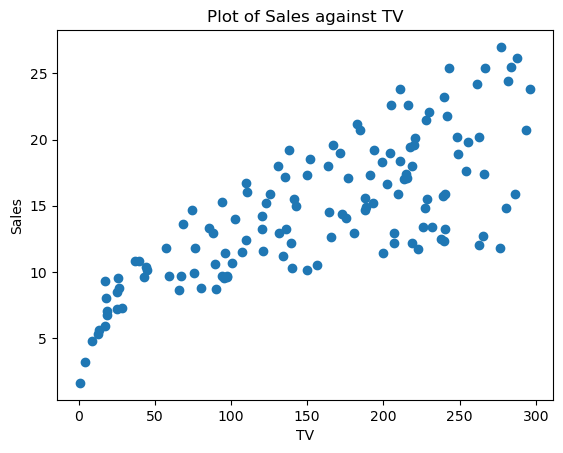

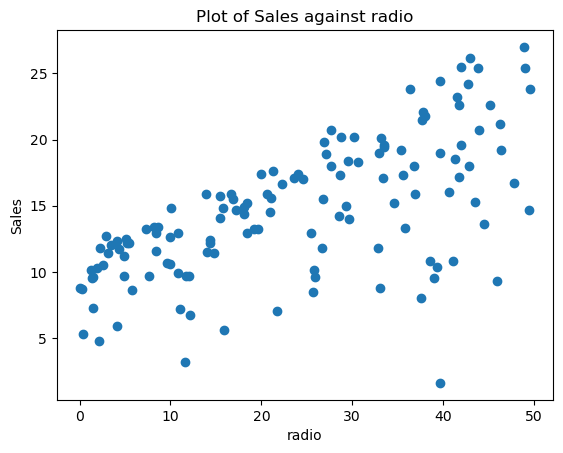

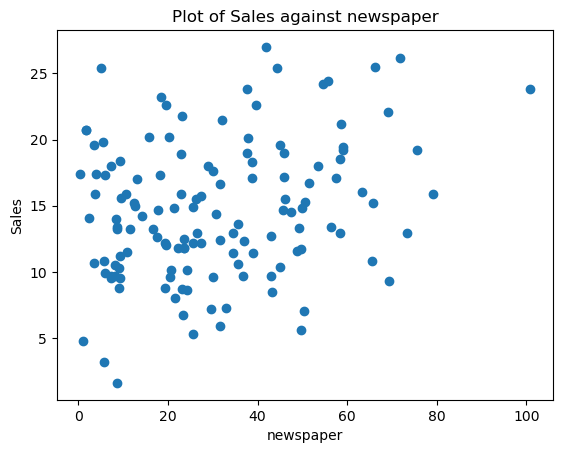

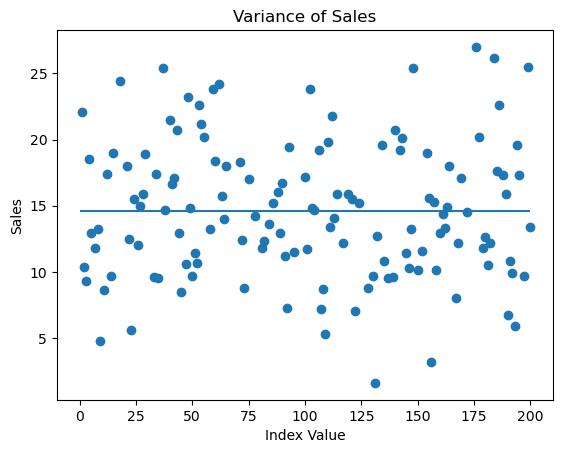

In [6]:
features = X_train.columns

for x in features:
    plt.scatter(X_train[x], y_train)
    plt.title(f'Plot of Sales against {x}')
    plt.xlabel(x)
    plt.ylabel('Sales')
    plt.show()
    
# also plot sales against itself
plt.scatter(y_train.index, y_train)
plt.hlines(y_train.mean(), 0, 200)
plt.xlabel('Index Value')
plt.ylabel('Sales')
plt.title('Variance of Sales')
plt.show()

A quicker solution is to use Seaborn's `pairplot`.  

This lets us check for linearity and multicollinearity (the next assumption we'll check) at the same time.

In [7]:
# Make a train df so we can see X versus y in our train data
train_df = pd.concat([X_train, y_train], axis=1)

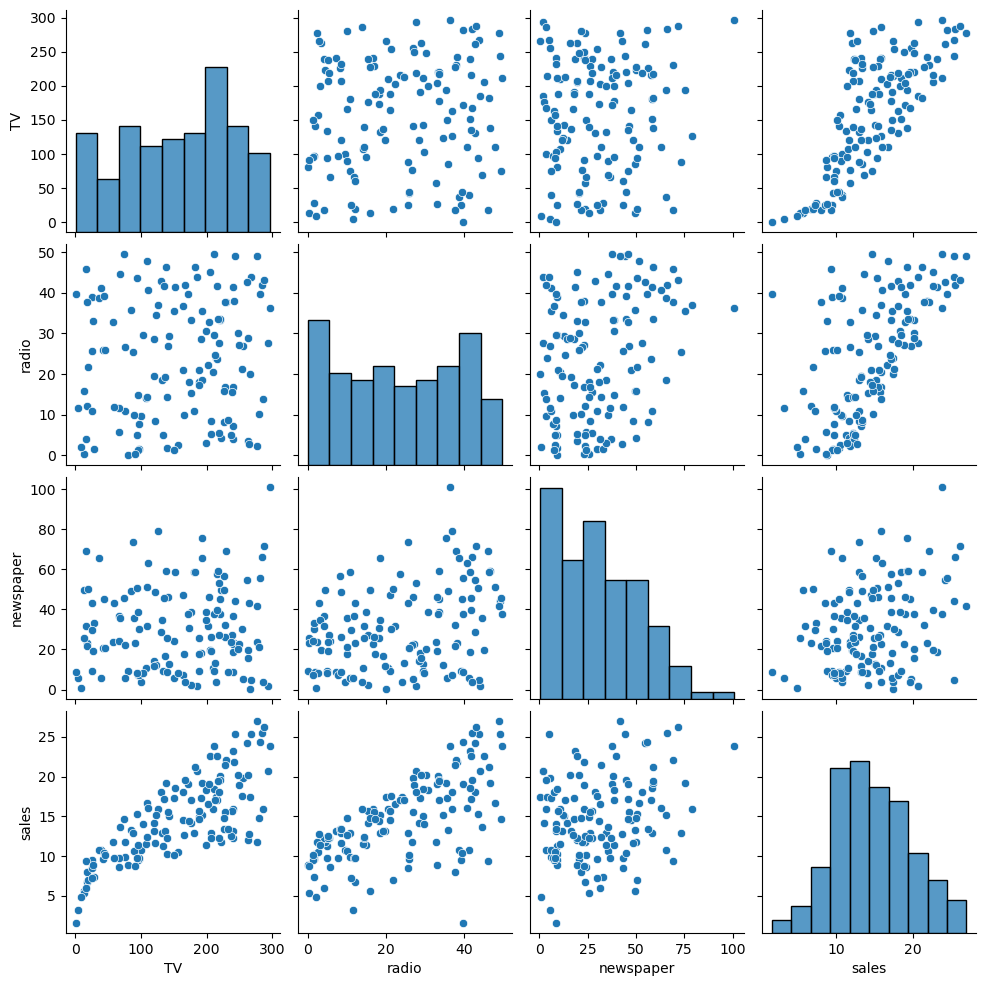

In [8]:
sns.pairplot(train_df)
plt.show()

#### Calculate Pearson's R Value

Pearson's R represents a correlation coefficient. 

In [15]:
# check correlations just against sales
train_df.corr().sales.sort_values(ascending=False)

sales        1.000000
TV           0.767758
radio        0.637572
newspaper    0.263108
Name: sales, dtype: float64

### Multicollinearity

AKA when my X variables aren't actually independent - so that a model has trouble determining which change in what X variable is actually influencing `y`.

This assumption can be checked by: 

- using scatterplots - plotting the independent variables against each other (pairplot, above)
- calculating correlations (bonus: visualizing them in a heatmap)
- calculating their Variable Inflation Factor (VIF) scores


#### Directly Explore Correlations

In [16]:
# check all correlations using the same Pearson's correlation coefficient
train_df.corr()

,TV,radio,newspaper,sales
TV,1.000000,0.097678,0.080101,0.767758
radio,0.097678,1.000000,0.324637,0.637572
newspaper,0.080101,0.324637,1.000000,0.263108
sales,0.767758,0.637572,0.263108,1.000000


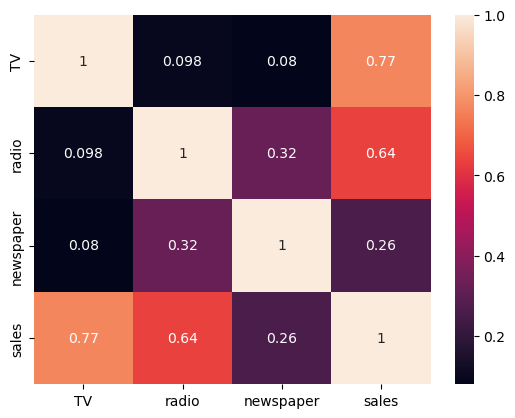

In [17]:
# can also visualize it
ax = sns.heatmap(train_df.corr(), annot=True)
# need to manually set my ylim because of my version of matplotlib
ax.set_ylim(4, 0)
plt.show()

#### Calculate the Variance Inflation Factor (VIF)

> "Variance inflation factor (VIF) is a measure of the amount of multicollinearity in a set of multiple regression variables. Mathematically, the VIF for a regression model variable is **equal to the ratio of the overall model variance to the variance of a model that includes only that single independent variable**. This ratio is calculated for each independent variable. A high VIF indicates that the associated independent variable is highly collinear with the other variables in the model."

-- Source: https://www.investopedia.com/terms/v/variance-inflation-factor.asp

In other words - how well does one of these X variables predict the others?

reference: https://www.geeksforgeeks.org/detecting-multicollinearity-with-vif-python/

In [18]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# defining an empty dataframe to capture the VIF scores
vif = pd.DataFrame()

# For each column,run a variance_inflaction_factor against all other columns to get a VIF Factor score
vif["VIF"] = [variance_inflation_factor(X_train.values, i) for i in range(len(X_train.columns))]

# label the scores with their related columns
vif["features"] = X_train.columns

vif

,VIF,features
0,2.881176,TV
1,3.453212,radio
2,3.180360,newspaper


## Checking Residuals

By checking the residuals, aka the error between our actual y values and what we predicted, we can check that:

- Errors are normally distributed with mean 0
- Errors are homoskedastic (aka they have constant variance)
- Errors are not correlated (no trends in error terms)

In a nutshell:

<img src="images/error-dist.jpeg" width="550">  


In [19]:
# Can't look at errors/residuals before modeling!
from sklearn.linear_model import LinearRegression

lr = LinearRegression()

lr.fit(X_train, y_train)

train_preds = lr.predict(X_train)
test_preds = lr.predict(X_test)

In [20]:
# Out of curiosity, check the score real fast
from sklearn.metrics import r2_score

print(f"Train R2: {r2_score(y_train, train_preds):.4f}")
print(f"Test R2: {r2_score(y_test, test_preds):.4f}")

Train R2: 0.9095
Test R2: 0.8556


### Normality

There are several ways to test for normality.

In [21]:
# Calculate our residuals
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds

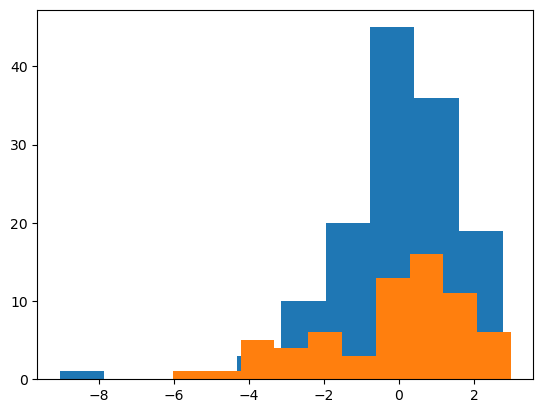

In [22]:
# Histogram of residuals
plt.hist(train_residuals, label='Train')
plt.hist(test_residuals, label='Test')

plt.show()

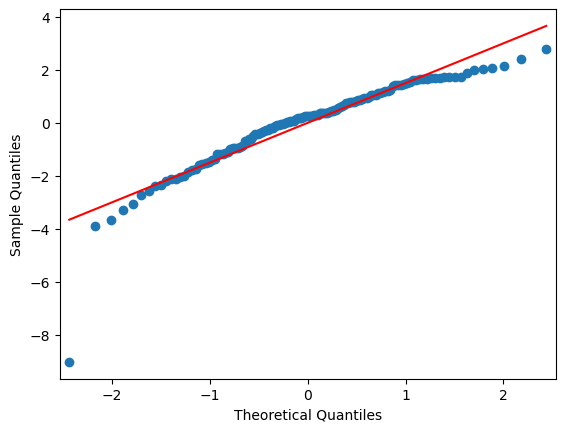

In [23]:
# QQ plots are generally great tools for checking for normality.
import statsmodels.api as sm

sm.qqplot(train_residuals, line = 'r');

### Heteroskedasticity and Lack of Trend in Errors - Use a Residual Plot

#### Typical Residuals vs. Predictions plots:

- **The ideal scenario**

    - Random scatter
    - Scattered around 0
    - No identifiable trend
    
    <img src="images/normal-resid.png" width="550">  
    
- **Non-linear relationship**

    - Clear non-linear scatter, but
    - Identifiable trend
    - **Fix:** Introduce polynomial terms
    - **Fix:** Variable transformation
    
    <img src="images/polynomial-resid.png" width="550">

- **Autocorrelation**

    - Identifiable trend, or
    - Consecutively positive/negative residuals
    - **Fix:** Consider sequential analysis methods (which we'll discuss in phase 4)
    
    <img src="images/autocorrelation.png" width="550">

- **Heteroskedasticity**

    - The spread of residuals is different at different levels of the fitted values
    - **Fix:** Variable transformation (log)  
    
    <img src="images/heteroskedasticity.png" width="550">
    


If you're just doing/exploring simple linear regression:

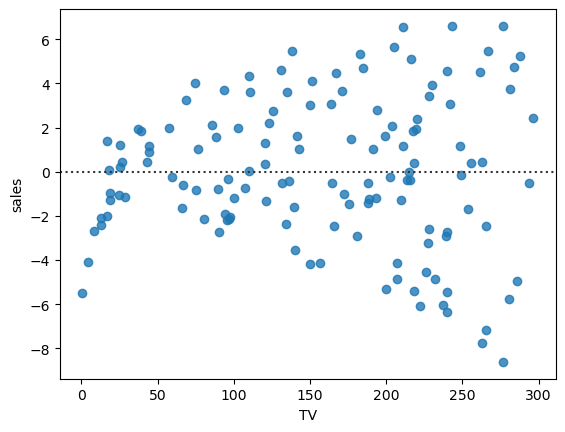

In [24]:
# note that these residplots only work for single variables
sns.residplot(x=X_train['TV'], y=y_train)
plt.show()

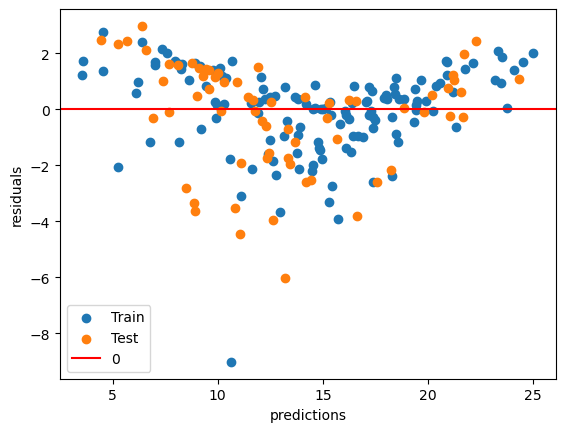

In [25]:
# for our full model
plt.scatter(train_preds, train_residuals, label='Train')
plt.scatter(test_preds, test_residuals, label='Test')

plt.axhline(y=0, color = 'red', label = '0')
plt.xlabel('predictions')
plt.ylabel('residuals')
plt.legend()
plt.show()

Note: a library named [Yellowbrick](https://www.scikit-yb.org/en/latest/index.html) has code for a nice Residuals Plot built out for you (works if you're using a sklearn model) - https://www.scikit-yb.org/en/latest/api/regressor/residuals.html

## Other Potential Problems

- Outliers

    <img src='images/outliers.png' width=450>

- High Leverage Points 

    <img src='images/leverage.png' width=450>

## Resources

- [Penn State Stats on Influential Points (outliers, high leverage points)](https://online.stat.psu.edu/stat462/node/87/) - this resource also allows easy access to the rest of their material on regression

- [Statsmodels' Documentation: Check the influence of outliers](https://www.statsmodels.org/devel/generated/statsmodels.stats.outliers_influence.OLSInfluence.html)

- [Long blog post on regression diagnostics with implementation in python](http://songhuiming.github.io/pages/2016/12/31/linear-regression-in-python-chapter-2/)

- [Statistics by Jim: Linear Regression Assumptions](https://statisticsbyjim.com/regression/ols-linear-regression-assumptions/)